In [8]:
from pathlib import Path
import os
import shutil
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

import json
from keras.models import model_from_json, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications import VGG16

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


(128, 128, 3)


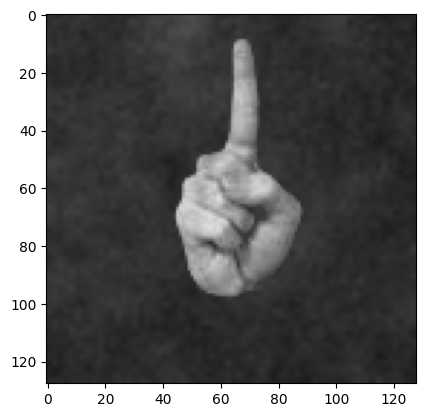

In [2]:
path = "archive(1)/valid/1.png"
img = cv2.imread(path)
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

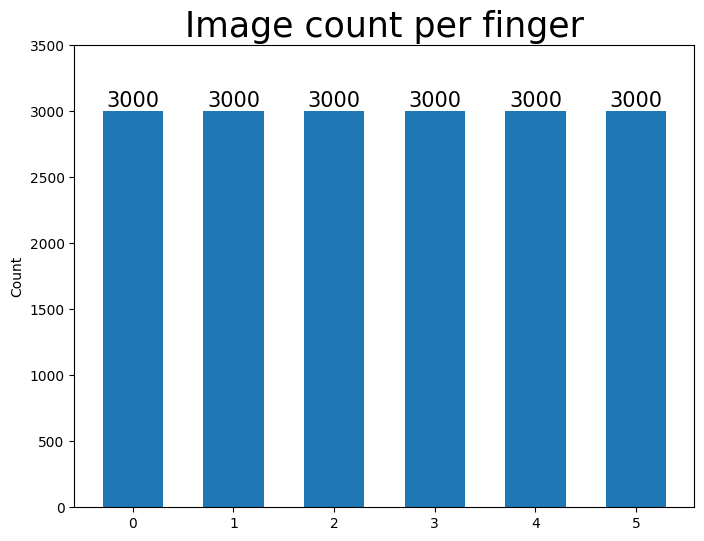

In [3]:
DIR_FINGERS = 'archive(1)'
counts = [0, 0, 0, 0, 0, 0]
totals = []
for partition in ['train']:
  total = 0
  for file in glob.glob(os.path.join(DIR_FINGERS, partition, '*')):
    counts[int(file.split(os.path.sep)[-1][-6])] += 1
    total += 1
  totals.append(total)

plt.figure(figsize=(8, 6))
bar = plt.bar([0, 1, 2, 3, 4, 5], height=counts, data=counts, align='center', width=0.6)
plt.ylim(0, max(counts)+500)
plt.ylabel('Count')
plt.title('Image count per finger', fontsize=25)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=15)

plt.show()


In [4]:
def resize(folder):
  for partition in ['train', 'test']:
    for file in glob.glob(os.path.join(folder, partition, '*')):
      img = cv2.imread(file)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      gray = cv2.resize(gray, TARGET_SIZE)
      cv2.imwrite(file, gray)

In [5]:
TARGET_SIZE = (128, 128)
resize(DIR_FINGERS)

In [6]:
def prepare_dataset(folder):
  data = []
  labels = []

  for partition in ['train', 'test']:
    print(partition)
    for file in sorted(glob.glob(os.path.join(folder, partition, '*'))):
      img = cv2.imread(file, 0)
      img = img_to_array(img)
      data.append(img)
      label = int(file.split(os.path.sep)[-1][-6])
      labels.append(label)
  return data, labels

In [9]:
data, labels = prepare_dataset(DIR_FINGERS)
print(labels)

train
test
[0, 0, 2, 0, 5, 5, 2, 2, 3, 0, 4, 2, 0, 1, 2, 3, 0, 3, 5, 5, 4, 0, 2, 2, 0, 5, 0, 0, 3, 3, 2, 1, 0, 0, 5, 4, 1, 0, 4, 4, 5, 1, 2, 2, 5, 3, 3, 4, 5, 3, 2, 2, 2, 2, 5, 0, 5, 5, 2, 2, 4, 3, 5, 0, 0, 4, 1, 0, 2, 0, 1, 5, 0, 4, 2, 3, 1, 0, 3, 2, 2, 0, 1, 0, 5, 1, 1, 1, 2, 2, 1, 2, 2, 5, 3, 4, 1, 0, 5, 2, 1, 5, 5, 5, 2, 4, 2, 4, 0, 2, 5, 3, 3, 1, 1, 1, 5, 1, 4, 4, 0, 4, 3, 2, 5, 2, 1, 2, 3, 2, 2, 1, 4, 5, 3, 1, 1, 4, 2, 5, 2, 0, 4, 1, 0, 1, 5, 2, 4, 2, 5, 4, 1, 3, 1, 2, 1, 0, 5, 4, 5, 0, 0, 0, 5, 1, 0, 1, 5, 4, 1, 0, 4, 2, 3, 5, 4, 0, 0, 5, 2, 3, 1, 3, 0, 0, 0, 0, 5, 1, 2, 4, 0, 4, 1, 3, 1, 2, 3, 0, 3, 0, 5, 3, 4, 2, 1, 4, 4, 0, 0, 0, 5, 3, 1, 2, 4, 5, 4, 4, 0, 4, 3, 3, 4, 1, 2, 3, 2, 0, 3, 4, 5, 4, 0, 3, 3, 5, 4, 5, 2, 3, 4, 5, 3, 5, 0, 3, 5, 2, 0, 3, 0, 3, 2, 2, 5, 3, 2, 3, 5, 2, 4, 0, 3, 5, 2, 2, 1, 5, 4, 2, 2, 3, 3, 3, 4, 3, 3, 4, 1, 3, 1, 1, 3, 3, 2, 3, 2, 0, 2, 2, 4, 2, 1, 4, 0, 5, 3, 0, 4, 3, 0, 3, 4, 5, 5, 5, 3, 4, 2, 1, 0, 0, 2, 3, 2, 0, 4, 1, 1, 1, 0, 0, 0, 1, 4, 4, 0, 0

In [10]:
def normalize(data, labels):
  data = np.array(data, dtype="float") / 255.0
  labels = np.array(labels)
  return data, labels

In [11]:
data, labels = normalize(data, labels)

In [12]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=131)

In [13]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 17280
number of test examples = 4320
X_train shape: (17280, 128, 128, 1)
Y_train shape: (17280, 6)
X_test shape: (4320, 128, 128, 1)
Y_test shape: (4320, 6)


In [15]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [58]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-3

In [37]:
def create_model():
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                  input_shape=(TARGET_SIZE[1], TARGET_SIZE[0], 1),
                  use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(6, activation='softmax', use_bias=False))
  return model

In [39]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      576       
                                                                 
 batch_normalization_12 (Ba  (None, 126, 126, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        36864     
                                                                 
 batch_normalization_13 (Ba  (None, 61, 61, 64)       

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)


135/135 [==============================] - 24s 163ms/step - loss: 0.0738 - accuracy: 0.9704
(128, 128, 1)
[1. 0. 0. 0. 0. 0.]
Test Loss: 0.07378208637237549
Test Accuracy: 0.970370352268219


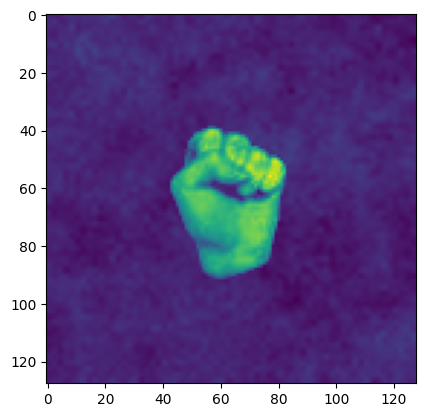

In [41]:
# Evaluate the model on the test data
plt.imshow(X_test[10])
loss, accuracy = model.evaluate(X_test, Y_test)

print(X_test[10].shape)
print(Y_test[10])
# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [42]:
image = X_test[10].reshape(1, 128, 128, 1)

predictions = model.predict(image)

predicted_label = np.argmax(predictions)

print("Predicted Label:", predicted_label)

print("Ground Truth Label:", Y_test[10])

1/1 [==============================] - 3s 3s/step
Predicted Label: 0
Ground Truth Label: [1. 0. 0. 0. 0. 0.]


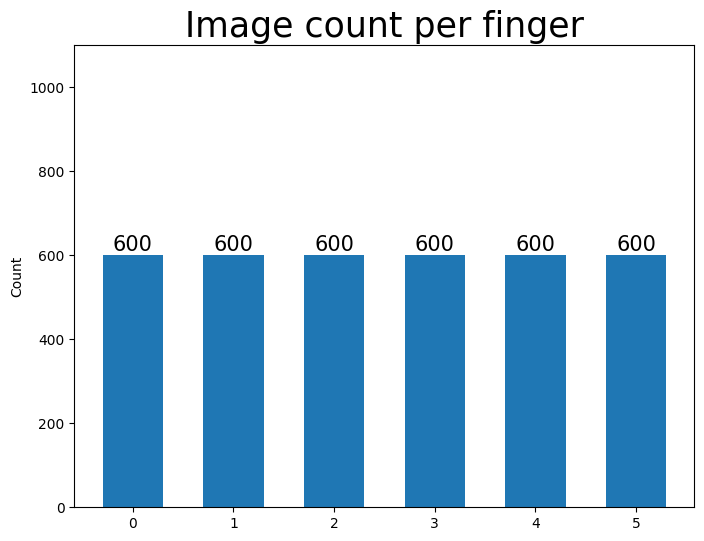

In [43]:
DIR_FINGERS = 'archive(1)'
counts = [0, 0, 0, 0, 0, 0]
totals = []
for partition in ['test']:
  total = 0
  for file in glob.glob(os.path.join(DIR_FINGERS, partition, '*')):
#     print(file,file.split(os.path.sep)[-1][-6])
    counts[int(file.split(os.path.sep)[-1][-6])] += 1
    total += 1
  totals.append(total)

plt.figure(figsize=(8, 6))
bar = plt.bar([0, 1, 2, 3, 4, 5], height=counts, data=counts, align='center', width=0.6)
plt.ylim(0, max(counts)+500)
plt.ylabel('Count')
plt.title('Image count per finger', fontsize=25)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=15)

plt.show()
# print(f'{totals[0]} train + {totals[1]} test = Total of {sum(totals)} images')

In [51]:
def prepare_dataset(folder):
  data = []
  labels = []

  for partition in ['test']:
    print(partition)
    for file in sorted(glob.glob(os.path.join(folder, partition, '*'))):
      img = cv2.imread(file, 0)
      img = img_to_array(img)
      data.append(img)
      label = int(file.split(os.path.sep)[-1][-6])
      labels.append(label)
  return data, labels

In [52]:
data_test, labels_test = prepare_dataset(DIR_FINGERS)
print(labels)

test
[0 0 2 ... 4 3 3]


In [53]:
data_test, labels_test = normalize(data_test, labels_test)

In [55]:
labels_test_encoded = to_categorical(labels_test, num_classes=6)

In [57]:
# Evaluate the model on the test data

loss, accuracy = model.evaluate(data_test, labels_test_encoded)

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


113/113 [==============================] - 19s 159ms/step - loss: 0.0676 - accuracy: 0.9758
Test Loss: 0.06757460534572601
Test Accuracy: 0.9758333563804626


(1, 128, 128, 1)


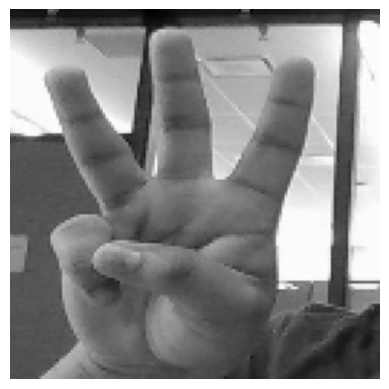

In [24]:
import cv2
import matplotlib.pyplot as plt

rgb_image = cv2.imread('archive(1)/3 Fingers Proper.jpg')

# Load the grayscale image
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)


resized_gray_image = cv2.resize(gray_image, (128, 128))
resized_gray_image_batch = resized_gray_image[np.newaxis, ..., np.newaxis]
print(resized_gray_image_batch.shape)

# Plot the grayscale image
plt.imshow(resized_gray_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


(1, 128, 128, 1)


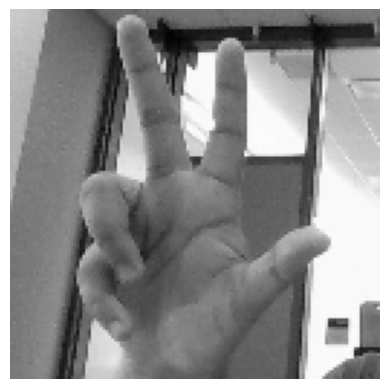

In [25]:
import cv2
import matplotlib.pyplot as plt

rgb_image = cv2.imread('archive(1)/3 Fingers.jpg')

# Load the grayscale image
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)


resized_gray_image = cv2.resize(gray_image, (128, 128))
resized_gray_image_batch = resized_gray_image[np.newaxis, ..., np.newaxis]
print(resized_gray_image_batch.shape)

# Plot the grayscale image
plt.imshow(resized_gray_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


In [26]:
predictions = model.predict(resized_gray_image_batch)

predicted_label = np.argmax(predictions)

print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 214ms/step
Predicted Label: 5


(1, 128, 128, 1)


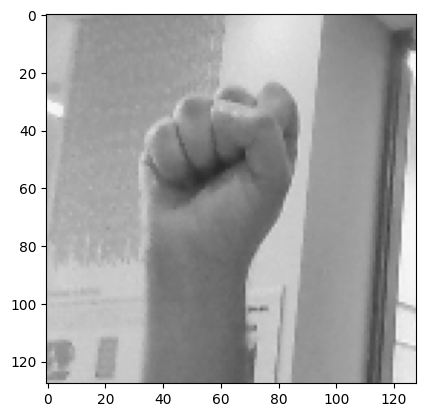

In [27]:
import cv2
import matplotlib.pyplot as plt

rgb_image = cv2.imread('archive(1)/No Fingers.png')

# Load the grayscale image
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)


resized_gray_image = cv2.resize(gray_image, (128, 128))
resized_gray_image_batch = resized_gray_image[np.newaxis, ..., np.newaxis]
# print(resized_gray_image_batch.shape)

# img = cv2.imread(path)
print(resized_gray_image_batch.shape)
plt.imshow(cv2.cvtColor(resized_gray_image, cv2.COLOR_BGR2RGB))


In [29]:
image = resized_gray_image_batch

predictions = model.predict(image)

predicted_label = np.argmax(predictions)

print("Predicted Label:", predicted_label)

# print("Ground Truth Label:", Y_test[10])

1/1 [==============================] - 0s 27ms/step
Predicted Label: 5
